In [38]:
import pandas as pd
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem import RWMol
from collections import defaultdict
from rdkit.Chem.rdDepictor import SetPreferCoordGen
SetPreferCoordGen(True)
from rdkit import RDPaths
import os

import pandas as pd
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem import RWMol
from collections import defaultdict
from rdkit.Chem.rdDepictor import SetPreferCoordGen
SetPreferCoordGen(True)
from rdkit import RDPaths
import os

In [39]:
#Read the data strutures
Suppl = Chem.SDMolSupplier('80-selected-cqr-conf.sdf')

In [40]:
## Remove the redundant structures
uni = []
uni_Stru = []

for x in Suppl:
    if x is not None:
        Name = x.GetProp('_Name')
        if Name not in uni:
            uni.append(Name)
            uni_Stru.append(x)

In [41]:
for m in uni_Stru:
    AllChem.Compute2DCoords(m)

In [42]:
mcs = rdFMCS.FindMCS(uni_Stru[:4], completeRingsOnly=True, ringMatchesRingOnly=True)

In [43]:
core = Chem.MolFromSmarts(mcs.smartsString)


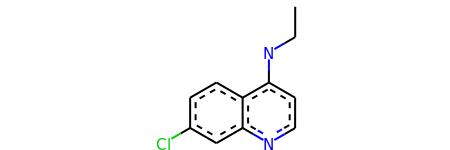

In [44]:
core

In [52]:
class RGroupDecomposer():
 
    def __init__(self, mols, core):
        self.mols = mols
        self.core = core
         
    def get_scaffold(self):
        emol = RWMol(self.core)
        atms = [a for a in emol.GetAtoms()]
        for a in atms:
            if not a.IsInRing():
                emol.RemoveAtom(a.GetIdx())
        return emol.GetMol()
     
    def rg_decompose(self):
        self.coremol = self.get_scaffold()
        self.match_mols = [mol for mol in self.mols if mol.HasSubstructMatch(self.coremol)]
        self.hmols = [Chem.AddHs(mol) for mol in self.match_mols]
        [AllChem.Compute2DCoords(mol) for mol in self.hmols]
        self.side_chains = [Chem.ReplaceCore(mol, self.coremol) for mol in self.hmols]
        self.core_info = Chem.ReplaceSidechains(self.hmols[0], self.coremol)
         
    def get_df(self):
        data = defaultdict(list)
        for i, side_chains in enumerate(self.side_chains):
            # Thank you for comment! fixed it
            data['mol'].append(Chem.MolToSmiles(self.match_mols[i]))
            side_chains = Chem.MolToSmiles(side_chains).split('.')
            for idx, side_chain in enumerate(side_chains):
                side_chain = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(side_chain)))
                data['R_{}'.format(idx+1)].append(side_chain)
            data['core'].append(Chem.MolToSmiles(self.core_info))
             
        df = pd.DataFrame(data)
        return df
 
# this is helper function to convert dataframe of smiles to dataframe of ROMol.
def allsmi2rdmol(df):
    cols = df.columns.to_list()
    for col in cols:
        PandasTools.AddMoleculeColumnToFrame(df, smilesCol=str(col), molCol=str(col))
    return df

In [45]:
class RGroupDecomposer():

    def __init__(self, mols, core):
        self.mols = mols
        self.core = core
        
    def get_scaffold(self):
        emol = RWMol(self.core)
        atms = [a for a in emol.GetAtoms()]
        for a in atms:
            if not a.IsInRing():
                emol.RemoveAtom(a.GetIdx())
        return emol.GetMol()
    
    def rg_decompose(self):
        self.coremol = self.get_scaffold()
        self.match_mols = [mol for mol in self.mols if mol.HasSubstructMatch(self.coremol)]
        self.hmols = [Chem.AddHs(mol) for mol in self.match_mols]
        [AllChem.Compute2DCoords(mol) for mol in self.hmols]
        self.side_chains = [Chem.ReplaceCore(mol, self.coremol) for mol in self.hmols]
        self.core_info = Chem.ReplaceSidechains(self.hmols[0], self.coremol)
        
    def get_df(self):
        data = defaultdict(list)
        for i, side_chains in enumerate(self.side_chains):
            data['mol'].append(Chem.MolToSmiles(self.match_mols[i]))
            side_chains = Chem.MolToSmiles(side_chains).split('.')
            for idx, side_chain in enumerate(side_chains):
                side_chain = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(side_chain)))
                data['R_{}'.format(idx+1)].append(side_chain)
            data['core'].append(Chem.MolToSmiles(self.core_info))
            
        df = pd.DataFrame(data)
        return df
    
# this is helper function to convert dataframe of smiles to dataframe of ROMol.
def allsmi2rdmol(df):
    cols = df.columns.to_list()
    for col in cols:
        PandasTools.AddMoleculeColumnToFrame(df, smilesCol=str(col), molCol=str(col))
    return df

In [ ]:
rgd = RGroupDecomposer(mols[:40], core)
rgd.rg_decompose()
df = rgd.get_df()
newdf = allsmi2rdmol(df)
from IPython.display import display_html
from IPython.display import HTML
HTML(df.to_html())

In [46]:
rgd = RGroupDecomposer(uni_Stru[:40], core)
rgd.rg_decompose()
df = rgd.get_df()

In [47]:
df.head(3)

,mol,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,core
0,CC[NH+](CCCCCNc1cc[nH+]c2cc(Cl)ccc12)CCNS(=O)(=O)c1cccc2c(N(C)C)cccc12,[1*]NCCCCC[NH+](CC)CCNS(=O)(=O)c1cccc2c(N(C)C)cccc12,[2*][H],[3*][H],[4*][H],[5*][H],[6*][H],[7*]Cl,[8*][H],[1*]c1c([2*])c([3*])[n+]([4*])c2c([8*])c([7*])c([6*])c([5*])c12
1,O=C(NCCCNc1cc[nH+]c2cc(Cl)ccc12)c1c(F)c(F)c(F)c(F)c1F,[1*]NCCCNC(=O)c1c(F)c(F)c(F)c(F)c1F,[2*][H],[3*][H],[4*][H],[5*][H],[6*][H],[7*]Cl,[8*][H],[1*]c1c([2*])c([3*])[n+]([4*])c2c([8*])c([7*])c([6*])c([5*])c12
2,CC[NH+](CCNc1cc[nH+]c2cc(Cl)ccc12)CCNS(=O)(=O)c1ccc(Oc2ccccc2)nc1,[1*]NCC[NH+](CC)CCNS(=O)(=O)c1ccc(Oc2ccccc2)nc1,[2*][H],[3*][H],[4*][H],[5*][H],[6*][H],[7*]Cl,[8*][H],[1*]c1c([2*])c([3*])[n+]([4*])c2c([8*])c([7*])c([6*])c([5*])c12


In [48]:
df.columns.to_list()

['mol', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'core']

In [51]:
newdf = allsmi2rdmol(df)
from IPython.display import display_html
from IPython.display import HTML
HTML(df.to_html())

TypeError: No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type Mol